# <a id='toc1_'></a>[**COVIDCast: Prophet Modeling and Forecasting**](#toc0_)

Sam Celarek   
Data Science   
scelarek@gmail.com   
August 4th, 2023  


**Table of contents**<a id='toc0_'></a>    
- [**COVIDCast: Prophet Modeling and Forecasting**](#toc1_)    
  - [Introduction to the Facebook Prophet Model](#toc1_1_)    
  - [Steps for Modeling with Prophet](#toc1_2_)    
- [Setting Up](#toc2_)    
  - [Variables Instantiation](#toc2_1_)    
  - [Functions](#toc2_2_)    
- [Base Model of Prophet](#toc3_)    
  - [Base Prophet Model](#toc3_1_)    
    - [Model Initialization](#toc3_1_1_)    
    - [Forecast Generation](#toc3_1_2_)    
    - [Model Evaluation](#toc3_1_3_)    
    - [Review Model Performance and 14 Day Forecast](#toc3_1_4_)    
- [Tuned Prophet Model](#toc4_)    
  - [Grid Search for Prophet Hyperparameters](#toc4_1_)    
  - [Tuned Model of Prophet](#toc4_2_)    
      - [Model Initialization](#toc4_2_1_1_)    
      - [Forecast Generation](#toc4_2_1_2_)    
      - [Model Evaluation](#toc4_2_1_3_)    
      - [Review Model Performance and 14 Day Forecast](#toc4_2_1_4_)    
- [Prophet Model with Tuning and Exogenous Variables](#toc5_)    
  - [Feature Selection](#toc5_1_)    
  - [Tuned and Exogenous Model of Prophet](#toc5_2_)    
      - [Model Initialization](#toc5_2_1_1_)    
      - [Forecast Generation](#toc5_2_1_2_)    
      - [Model Evaluation](#toc5_2_1_3_)    
      - [Review Model Performance and 14 Day Forecast](#toc5_2_1_4_)    
- [Best COVID Forecaster](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


## <a id='toc1_1_'></a>[Introduction to the Facebook Prophet Model](#toc0_)

Facebook's Prophet is a forecasting tool tailored for time series data that displays strong seasonal patterns. It's particularly designed for scenarios where multiple seasonality patterns with varying scales exist, such as yearly, weekly, and daily cycles. Prophet is also equipped to handle holidays and special events which can significantly influence time series patterns.

The model has certain expectations regarding input data:
- The datetime column should be named `ds`.
- The target variable column should be named `y`.

The modeling process can be broken down into a series of structured steps.

## <a id='toc1_2_'></a>[Steps for Modeling with Prophet](#toc0_)

1. **Model Initialization:** Set up the Prophet model, including any parameter tuning and additional regressors.
2. **Forecast Generation:** Use the initialized model to generate predictions for a given horizon.
3. **Model Visual Evaluation:** Assess the model's performance using visual diagnostics.
   -  This includes in-sample and out-of-sample prediction evaluation (a), cross-validation (b), and component analysis (c).
4. **Model Statistical Evaluation:** Assess the model's performance using common error metrics for time series analysis.


# <a id='toc2_'></a>[Setting Up](#toc0_)

In [2]:
# Import necessary functions from the 'capstone_functions' module
from capstone_functions import *

# Set the plotting style to 'seaborn' for better visualization
plt.style.use('seaborn')

# Suppress any warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set a fixed random seed for reproducibility of results
np.random.seed(42)


Versions used in this notebook:
Python version: 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.2
Matplotlib version: 3.7.1
Scipy version: 1.10.1
Statsmodels version: 0.14.0
SKLearn version: 1.2.2


C:\Users\Samsickle\AppData\Local\Temp\ipykernel_3904\45557475.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:

# Built-in libraries
from IPython.display import display, Markdown, HTML

# Matplotlib
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Prophet
from prophet.plot import plot_cross_validation_metric, plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Other libraries
import scipy.stats as stats
import itertools


In [4]:
# Read the parquet file and store its contents in the 'master_df' DataFrame
master_df = pd.read_parquet("../Data/master_df.parquet")

# Display basic information about the DataFrame (e.g., column data types, non-null values, etc.)
master_df.info()

# Display the first five rows of the DataFrame to get a quick overview
master_df.tail()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2020-02-15 to 2023-03-21
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         1131 non-null   int32  
 1   new_hospitalized_patients             944 non-null    float64
 2   current_hospitalized_patients         1131 non-null   float64
 3   current_intensive_care_patients       1131 non-null   float64
 4   new_fatal                             1131 non-null   int32  
 5   average_temperature_celsius           943 non-null    float64
 6   cancel_events                         1131 non-null   float32
 7   confirmed                             1131 non-null   int32  
 8   cumulative_hospitalized_patients      944 non-null    float64
 9   derived_reproduction_rate             1131 non-null   float64
 10  dew_point                             943 non-null    float64
 11 

,new_confirmed,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_fatal,average_temperature_celsius,cancel_events,confirmed,cumulative_hospitalized_patients,derived_reproduction_rate,...,transport_closing,vaccination_policy,workplace_closing,dayofweek,quarter,month,year,dayofyear,dayofmonth,new_bi_weekly_vaccinations
date,,,,,,,,,,,,,,,,,,,,,
2023-03-17,18756,NaN,16437.0,2110.0,363,NaN,0.0,103782317,NaN,1.170246,...,0.0,NaN,1.0,4,1,3,2023,76,17,824426.0
2023-03-18,1175,NaN,16056.0,2067.0,2,NaN,0.0,103783492,NaN,1.170246,...,0.0,NaN,1.0,5,1,3,2023,77,18,773329.0
2023-03-19,1424,NaN,16158.0,2091.0,0,NaN,0.0,103784916,NaN,1.170246,...,0.0,NaN,1.0,6,1,3,2023,78,19,755935.0
2023-03-20,9787,NaN,16555.0,2179.0,138,NaN,0.0,103794703,NaN,1.170246,...,0.0,NaN,1.0,0,1,3,2023,79,20,799475.0
2023-03-21,18373,NaN,16301.0,2189.0,213,NaN,0.0,103813076,NaN,1.170246,...,0.0,NaN,1.0,1,1,3,2023,80,21,792508.0


## <a id='toc2_1_'></a>[Variables Instantiation](#toc0_)

These Variables *must* be set for some of the code to run properly. Please set them appropriately for whichever metric you are running.

In [5]:
# Reset the index of the DataFrame and rename the 'date' column to 'ds' and 'new_confirmed' column to 'y'
# This is done to make the DataFrame compatible with Facebook Prophet's expected input format

# LOGISTIC GROWTH MODEL REQUIRED VALUES
# Define the upper limit (cap) and lower limit (floor) for the logistic growth

master_df = master_df.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}).copy()
master_df['cap'] = master_df['susceptible']
master_df['floor'] = 0

In [6]:

# CROSS VALIDATION REQUIRED VALUES
# Define the prediction horizon: how many days in the future we want to forecast
cutoff_period_prediction = 14

# Define the warmup period for the model, typically the initial days where no prediction is made to let the model adjust
initial_warmup_period = 366

# Calculate the date where the training data ends and the test data begins
cutoff_date = master_df.ds.max() - pd.Timedelta(days=cutoff_period_prediction)

# Date to forecast from
choose_your_date = pd.Timestamp('2023-03-01')



Train Test Split

In [7]:
# Drop columns that have any null values to ensure completeness of the dataset
no_null_col = master_df.dropna(axis=1).copy()

# Split the data into training set (all data up to the cutoff_date) and test set (all data after the cutoff_date)
train_df = no_null_col[no_null_col.ds < cutoff_date].copy()
test_df = no_null_col[no_null_col.ds >= cutoff_date].copy()

# Print out the shapes and the cutoff date for better understanding of the data
print(f"Shape of the dataset after dropping columns with null values: {no_null_col.shape}")
print(f"Cutoff date for training and testing split: {cutoff_date}")
print(f"Shape of the training dataset: {train_df.shape}")
print(f"Shape of the testing dataset: {test_df.shape}")


Shape of the dataset after dropping columns with null values: (1131, 47)
Cutoff date for training and testing split: 2023-03-07 00:00:00
Shape of the training dataset: (1116, 47)
Shape of the testing dataset: (15, 47)


In [8]:
# Splitting the 'ds' (date) and 'y' (target variable) from the training and testing datasets for Prophet
y_train = train_df[['ds','y']].copy()
y_test = test_df[['ds','y']].copy()

# Extracting all other features (excluding 'ds' and 'y') from the training and testing datasets
X_train = train_df.drop(columns=['y']).copy()
X_test = test_df.drop(columns=['y']).copy()

# Print the shapes
print(f"Shape of the y_train dataframe (target variable for training): {y_train.shape}")
print(f"Shape of the y_test dataframe (target variable for testing): {y_test.shape}")
print(f"Shape of the X_train dataframe (features for training): {X_train.shape}")
print(f"Shape of the X_test dataframe (features for testing): {X_test.shape}")


Shape of the y_train dataframe (target variable for training): (1116, 2)
Shape of the y_test dataframe (target variable for testing): (15, 2)
Shape of the X_train dataframe (features for training): (1116, 46)
Shape of the X_test dataframe (features for testing): (15, 46)


Variables Used in Analysis

In [9]:
# all variables
all_variables = train_df.drop(columns=['ds', 'y','floor', 'cap']).columns.tolist()

# Collinear variables
colinear_variables = ['confirmed', 'susceptible', 'infected', 'recovered', 'total_removed', 'new_recovered', 'new_susceptible']

Not_Colin = list(set(all_variables) - set(colinear_variables))

# Columns related to target variables
target_variables = ['ds', 'y']

# Define a list of most important features based on prior knowledge or feature importance from another model
most_important = ['stringency_index', 'derived_reproduction_rate', 'new_bi_weekly_vaccinations', 
                'current_hospitalized_patients', 'excess_mortality']

# Define a list of somewhat important features based on prior knowledge or feature importance from another model
somewhat_important =  ['month', 'total_vaccinations', 'dayofmonth', 'stringency_index', 
                    'excess_mortality_cumulative', 'current_intensive_care_patients',
                    'current_hospitalized_patients', 'derived_reproduction_rate',
                    'gatherings_restrictions', 'cancel_events', 't/s_recovery_period',
                    'new_bi_weekly_vaccinations', 'excess_mortality', 'testing_policy',
                    'international_movement_restrictions', 'stay_home_restrictions',
                    'quarter', 'kap_mortality_rate', 'workplace_closing',
                    'internal_movement_restrictions', 'information_campaigns',
                    'transport_closing', 'school_closing', 'rho_transmission_rate',
                    'new_vaccinations', 'sig_recovery_rate', 't/r_infection_period',
                    'new_fatal', 't/k_mortality_period', 'dayofweek']

# Define a list of exploratory variables that might be considered for model enhancements or fine-tuning
frequently_removed_variables =  list(set(train_df.columns) - set(['ds', 'y', 'cap', 'floor', 
                        'confirmed', 'susceptible', 'fatal', 'infected', # removed 4
                        'excess_mortality', 'total_removed', 'dayofmonth', # removed 7
                        'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute', 'people_fully_vaccinated', 'people_vaccinated', #removed 11
                        # 'transport_closing', 'workplace_closing', 'dayofweek', 'quarter', # removed 15
                        # 'derived_reproduction_rate', 'cancel_events', 'gatherings_restrictions',  
                        # 'information_campaigns', 'internal_movement_restrictions', # removed 20
                        # 't/k_mortality_period', 't/r_infection_period', 't/s_recovery_period', # removed 23
                        'new_recovered', 'new_susceptible', 'recovered', # removing colinear variables
                        # 'sig_recovery_rate', 'rho_transmission_rate', 'kap_mortality_rate', # removed 26
                        # 'new_fatal', 'school_closing', # removed 28
                        ]))

# Variables related to the SIRD model parameters and characteristics
sird_variables = ['rho_transmission_rate', 'sig_recovery_rate', 'derived_reproduction_rate', 
                'kap_mortality_rate', 't/k_mortality_period', 't/r_infection_period', 
                't/s_recovery_period']

# Variables related to date components
date_variables = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth']

# Variables related to restrictions and governmental measures
restriction_variables = ['stay_home_restrictions', 'gatherings_restrictions', 
                        'internal_movement_restrictions', 'international_movement_restrictions',  
                        'cancel_events', 'school_closing', 'transport_closing', 'workplace_closing', 
                        'testing_policy', 'stringency_index', 'information_campaigns']

# Variables related to the epidemiological data and progress of the disease
epidemiological_variables = ['fatal', 'excess_mortality',  
                            'new_fatal', 
                            'excess_mortality_cumulative', 'excess_mortality_cumulative_absolute',
                            'new_vaccinations', 'people_fully_vaccinated', 'people_vaccinated', 
                            'new_bi_weekly_vaccinations', 'total_vaccinations',
                            'current_hospitalized_patients', 'current_intensive_care_patients']


In [10]:

# Initialize dataframes to hold evaluation metrics for validation, in-sample, and out-of-sample predictions
val_eval_holder = pd.DataFrame().rename_axis('Validation Metric', axis=1)
in_sample_eval_holder = pd.DataFrame().rename_axis('In-Sample Metric', axis=1)
out_of_sample_eval_holder = pd.DataFrame().rename_axis('Out-of-Sample Metric', axis=1)



## <a id='toc2_2_'></a>[Functions](#toc0_)
Setting up functions that are repeatedly used through the prophet notebook

In [11]:
def residual_plotter(forecast_df, yhat_col='yhat', original_col='y_train', simple=True, title='Prophet'):
    """
    Plots residual diagnostics and returns evaluation metrics for a forecast dataframe from Prophet.
    
    Parameters:
    - forecast_df: DataFrame from Prophet prediction.
    
    Returns:
    - scores: Series with R2, MAE, RMSE, and SMAPE scores.
    """
    
    forecast_df = forecast_df.dropna(subset=[original_col,yhat_col])
    
    # Calculate residuals
    residuals = (forecast_df[original_col] - forecast_df[yhat_col]).dropna()
    
    # Ensure residuals are in the correct format
    residuals = pd.Series(residuals, dtype=float)
    
    lags = int(min(20, round(len(residuals)/3) - 1))
    
    if simple:

        # Plot Histogram
        sns.histplot(residuals, kde=True, stat='density', ax=plt.gca(), label=f'{original_col} Residuals')
        plt.title(f"{title} Model\nHistogram of Residuals")
        plt.xlabel("Residual")
        plt.ylabel("Density")
        
        
    else:
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))

        # Plot Histogram
        sns.histplot(residuals, kde=True, ax=ax[0,0])
        ax[0,0].set_title("Histogram of Residuals")
        ax[0,0].set_xlabel("Residual")
        ax[0,0].set_ylabel("Frequency")
        ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)
        
        
        # QQ Plot
        stats.probplot(residuals, dist="norm", plot=ax[0,1])
        ax[0,1].set_title("Q-Q Plot of Residuals")
        ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # ACF and PACF plots
        sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=ax[1,0])
        sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=ax[1,1])
        
        ax[1,0].set_title("ACF of Residuals")
        ax[1,1].set_title("PACF of Residuals")
        
        plt.suptitle(f"{title} Model\nResidual Diagnostics")
        
        plt.tight_layout()
        plt.show()
    
    
    # Evaluation Metrics
    r2 = r2_score(forecast_df[original_col], forecast_df[yhat_col])
    mae = mean_absolute_error(forecast_df[original_col], forecast_df[yhat_col])
    rmse = mean_squared_error(forecast_df[original_col], forecast_df[yhat_col], squared=False)
    smape_score = smape(forecast_df[original_col], forecast_df[yhat_col])
    
    scores = pd.Series({
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'SMAPE': smape_score
    })
    
    return scores #, residuals


# Examples of Usage:
# residual_plotter(forecast_df, yhat_col='yhat', original_col='y_train', simple=True, title=title)
# residual_plotter(forecast_df, yhat_col='yhat', original_col='y_test', simple=True, title=title)


In [12]:
def forecast_df_complete(model, y_train, y_test, exogenous_df=None, horizon=cutoff_period_prediction):
    """
    Generates a complete forecast dataframe using the given Prophet model and exogenous data.
    
    Parameters:
    - model: A trained Prophet model.
    - y_train: DataFrame containing training data with 'ds' (date) and 'y' (target variable).
    - y_test: DataFrame containing test data with 'ds' (date) and 'y' (target variable).
    - exogenous_df (optional): DataFrame containing exogenous features for Prophet.

    Returns:
    - forecast_df: A DataFrame containing predictions, as well as actual values from y_train and y_test.
    """

    # Create a future dataframe for the specified period using the Prophet model
    prophet_model_df = model.make_future_dataframe(horizon, freq='D', include_history=True)
    
    # If exogenous data is provided, merge it with the future dataframe on date ('ds')
    if exogenous_df is not None:
        try:
            exogenous_df = exogenous_df.drop(columns=['y']).copy()
        except:
            pass
        
        prophet_model_df = prophet_model_df.merge(exogenous_df, on='ds', how='left')

    # Predict using the Prophet model
    forecast_df = model.predict(prophet_model_df)
    
    # Merge the predictions dataframe with y_train and y_test to include actual values
    forecast_df = forecast_df.merge(y_train, on='ds', how='left').copy()
    forecast_df = forecast_df.merge(y_test, on='ds', how='left', suffixes = ['_train', '_test']).copy()
    
    return forecast_df

# forecast_df = forecast_df_complete(model, y_train, y_test, exogenous_df=train_df)

In [13]:
def prophet_cross_validation(model, title='Prophet'):
    """
    Perform cross-validation on a given Prophet model and visualize the RMSE and sMAPE metrics.
    
    Parameters:
    - model (Prophet object): The trained Prophet model for forecasting.
    - title (str): The title for the visualization plot.
    
    Returns:
    - scores (pd.Series): Series with the mean values of the performance metrics from cross-validation.
    
    Note:
    - The function uses global variables `initial_warmup_period` and `cutoff_period_prediction` for 
      setting up the cross-validation parameters.
    """
    
    # Run cross-validation
    df_cv = cross_validation(
        model,
        initial=f"{initial_warmup_period} days",
        # period=f"{cutoff_period_prediction} days",
        horizon=f"{cutoff_period_prediction} days",
        parallel="processes"
    )
    
    # Get performance metrics
    scores = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))
    
    # Setup the subplot grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot the forecast vs actual on the left side (ax1)
    df_cv.plot(x='ds', y='y', ax=ax1, linewidth=2, color='black', label='Actual')
    df_cv.plot(x='ds', y='yhat', ax=ax1, linewidth=2, color='blue', linestyle='--', label='Predicted')
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

    # Add faint red dashed lines for every unique value in the cutoff column
    # for date in df_cv['cutoff'].unique():
    #     ax1.axvline(date, color='red', linestyle='--', alpha=0.5)
    
    ax1.set_title(f'{title} Model\nCross-Validation Predictions', fontsize=18)
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('Value', fontsize=14)
    ax1.legend(fontsize=12)

    # Plot RMSE on the primary Y-axis on the right side (ax2)
    plot_cross_validation_metric(df_cv, metric='rmse', ax=ax2, rolling_window=0.1)
    ax2.set_title(f'{title} Model\nCross-Validation Scores on Forecasting out {cutoff_period_prediction} Days', fontsize=16)
    ax2.set_ylabel('RMSE')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

    # Create a secondary Y-axis for sMAPE
    ax3 = ax2.twinx()
    plot_cross_validation_metric(df_cv, metric='smape', ax=ax3, color='r')
    ax3.set_ylabel('sMAPE (%)')
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))

    # Set legend using the line objects
    # ax2.legend(ax2.lines[1] + ax3.lines[1], ('RMSE', 'sMAPE'), loc='upper left')

    plt.tight_layout()
    plt.show()
    
    return scores


# scores = prophet_cross_validation(model, title)
# print(scores)


In [14]:
def prophet_model_eval_pipeline(model, forecast_df, title='Prophet'):
    """
    Execute a comprehensive pipeline for the Prophet model encompassing forecasting, visualization, and evaluation.
    
    Parameters:
    - model (Prophet object): The Prophet model instance.
    - forecast_df (pd.DataFrame): DataFrame containing forecast values along with other components.
    - title (str): Title for plots and naming in evaluation holders.
    
    Returns:
    - model (Prophet object): The trained Prophet model.
    - forecast_df (pd.DataFrame): DataFrame with forecast values.
    """
    global in_sample_eval_holder, out_of_sample_eval_holder, val_eval_holder
    
    # --------------- 3a. Plot In-Sample and Out-Of-Sample Predictions ---------------
    display(Markdown("### 3a. Plot In-Sample and Out-Of-Sample Predictions"))

    # Create and display the forecast plot
    fig = plot_plotly(model, forecast_df, xlabel='Date', ylabel='Value')
    fig.add_trace(go.Scatter(x=forecast_df.ds, y=forecast_df['y_test'], mode='lines', name='Predict Test Data Points', line=dict(color='green')))

    # Update layout for clarity and legend naming
    fig.update_layout(
        title=f"{title} Model Forecast vs Actual Data",
        xaxis_title="Date",
        yaxis_title="Value",
        legend_title="Legend",
        showlegend=True
    )
    fig.data[4].name = 'Change Point'
    fig.data[3].name = '95% Confidence Interval'
    fig.data[1].name = ''

    fig.show();

    # Display residuals and their evaluations
    in_sample_eval_holder[f'{title} Model'] = residual_plotter(forecast_df, yhat_col='yhat', original_col='y_train', title=title)
    out_of_sample_eval_holder[f'{title} Model'] = residual_plotter(forecast_df, yhat_col='yhat', original_col='y_test', title=title)
    plt.legend();
    plt.show()

    # --------------- 3b. Plot Cross-Validation Predictions ---------------
    display(Markdown("### 3b. Plot Cross-Validation Predictions"))
    val_eval_holder[f'{title} Model'] = prophet_cross_validation(model, title)
    plt.show()

    # --------------- 3c. Plot the Components and Interpret ---------------
    display(Markdown("### 3c. Plot the Components and Interpret"))
    fig = model.plot_components(forecast_df)
    fig.suptitle(f'{title} Model\nSeasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
    fig.show();


# Example of usage:
# prophet_model_eval_pipeline(model, forecast_df=forecast_df, title=title)


15:07:19 - cmdstanpy - INFO - Chain [1] start processing
15:07:20 - cmdstanpy - INFO - Chain [1] done processing


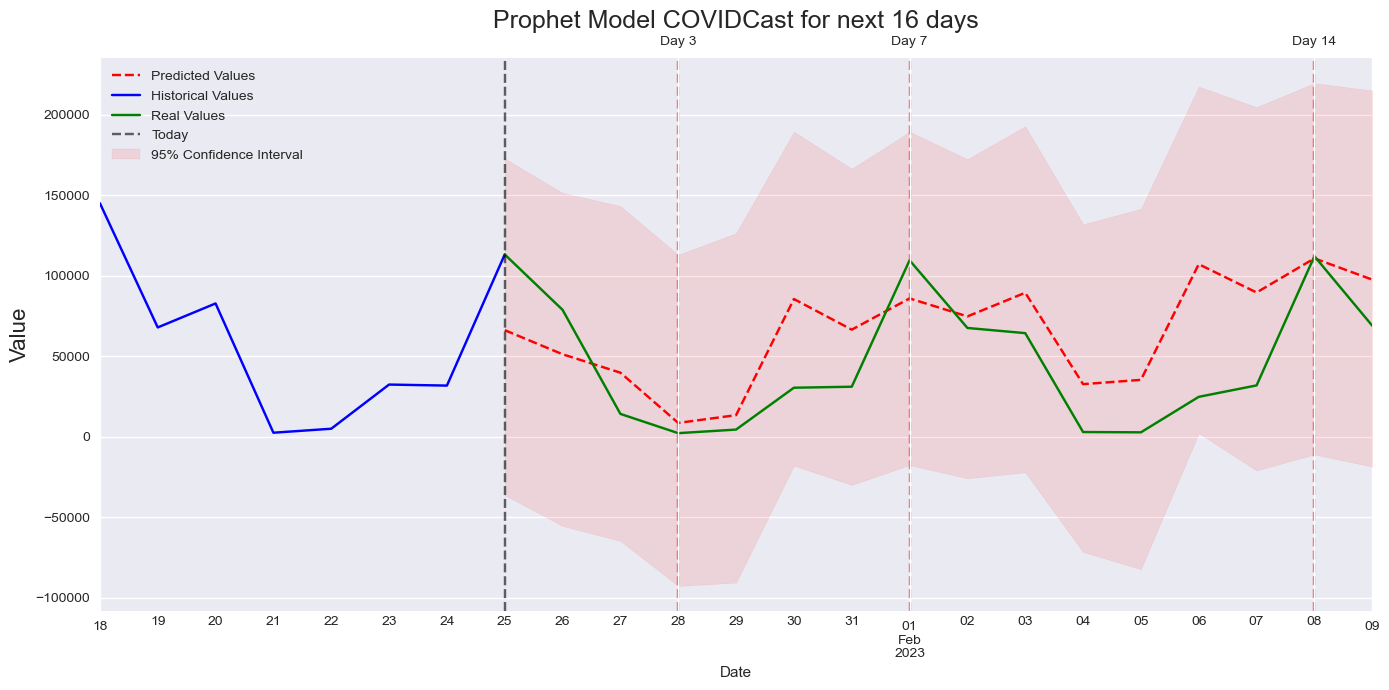

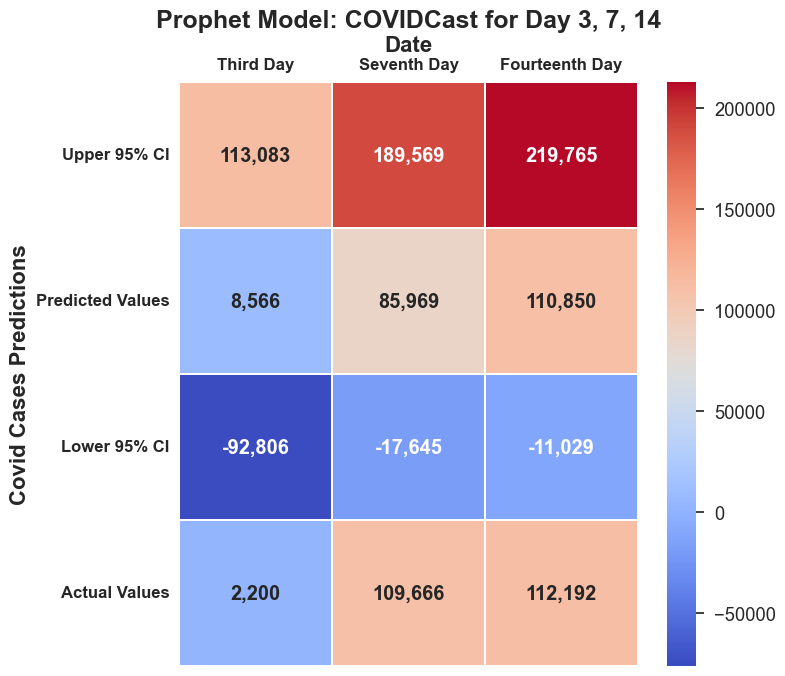

In [16]:

def COVIDCast(model, choose_your_date, df=master_df, title='Prophet', horizon=16, target='y', exogenous=None):
    """
    Generates a forecast using the Prophet model and plots the results.
    
    Parameters:
    ----------
    model : Prophet model instance
        The Prophet model to be used for forecasting.
    
    choose_your_date : pd.Timestamp
        A timestamp representing the start date for the prediction.
    df : pd.DataFrame, default=master_df
        The dataset used for the forecasting.
    title : str, default='Prophet'
        A string representing the title for the plots.
    horizon : int, default=16
        The number of days to forecast ahead.
    target : str, default='y'
        The column name in the dataframe representing the target variable for forecasting.
    exogenous : list, default=None
        List of columns in the dataframe to be considered as exogenous variables.
        
    Returns:
    -------
    COVIDCast : pd.DataFrame
        A DataFrame containing the forecasted results.
    """
    
    
    ######################## Creating Future Forecast ################################
    # Calculate relevant dates
    start_date = choose_your_date - pd.Timedelta(days=7)
    day3 = choose_your_date + pd.Timedelta(days=3)
    day7 = choose_your_date + pd.Timedelta(days=7)
    day14 = choose_your_date + pd.Timedelta(days=14)
    end_date = choose_your_date + pd.Timedelta(days=horizon-1)
    dates_ls = [day3, day7, day14]


    assert df.ds.min() + pd.Timedelta(days=366) < choose_your_date, 'Please choose a date after 2021-02-22'
    assert end_date <= df.ds.max(), 'Please choose a date + horizon before 2023-03-22'
    
    # Pre-process data
    no_null_col = master_df.dropna(axis=1)  # Remove columns with null values
    train_df = no_null_col[no_null_col.ds < choose_your_date]  # Training data
    test_df = no_null_col[(no_null_col.ds >= choose_your_date) & (no_null_col.ds <= end_date)]  # Test data

    # Fit the model to the training data
    model = model.fit(train_df)
    

    # Make future predictions
    results = forecast_df_complete(model, y_train, y_test, master_df, horizon = horizon).drop(columns = ['cap'])

    # Merge forecast results with actual values, Create CovidCast Df
    cast_outcome = pd.merge(results[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
                            master_df[['ds', target]], on='ds', how='left')
    COVIDCast = cast_outcome[(cast_outcome.ds <= end_date) & (cast_outcome.ds >= start_date)]
    COVIDCast.set_index('ds', inplace=True)
    COVIDCast[target] = COVIDCast[target].astype(int)
    
    # Compute residuals and sMAPE for forecast accuracy
    COVIDCast['residuals'] = COVIDCast[target] - COVIDCast['yhat']
    COVIDCast['sMAPE'] = 100 * np.abs(COVIDCast[target] - COVIDCast['yhat']) / (np.abs(COVIDCast[target]) + np.abs(COVIDCast['yhat']) /2)

    ######################## Plotting Line Graph ################################
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    COVIDCast.iloc[7:,:].plot(y='yhat', ax=ax, label='Predicted Values', color='red', linestyle='--')
    
    COVIDCast.iloc[:8,:].plot(y=target, ax=ax, label='Historical Values', color='blue')
    
    COVIDCast.iloc[7:,:].plot(y=target, ax=ax, label='Real Values', color='green')

    ax.axvline(x=choose_your_date, color='black', linestyle='--', alpha=0.6, label='Today')
    for i in dates_ls:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.6)
        
    ax.fill_between(COVIDCast.index[7:], COVIDCast.loc[choose_your_date:,'yhat_lower'], 
                    COVIDCast.loc[choose_your_date:,'yhat_upper'], color='red', 
                    alpha=0.1, label='95% Confidence Interval')
    
    
    # Create a secondary x-axis at the top
    ax2 = ax.twiny()

    # Set the xtick labels for day 3, 7, and 14 on the secondary x-axis
    ax2.set_xticks(dates_ls)
    ax2.set_xticklabels(['Day 3', 'Day 7', 'Day 14'])
    ax2.set_xlim(ax.get_xlim())  # Ensure the secondary axis has the same limits as the original axis

    # Set title with larger font and increase y-axis label font size
    plt.title(f'{title} Model COVIDCast for next {horizon} days', fontsize=18)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value', fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.show()


    ######################## Plotting Heatmap ################################
    # Generate heatmap for days 3, 7, and 14
    microCast = COVIDCast.loc[dates_ls].rename(index={day3: 'Third Day', 
                                                    day7: 'Seventh Day', 
                                                    day14: 'Fourteenth Day'})
    microCast = microCast.rename(columns={'y': 'Actual Values', 
                                        'yhat': 'Predicted Values', 
                                        'yhat_lower': 'Lower 95% CI', 
                                        'yhat_upper': 'Upper 95% CI',
                                        'residuals': 'Error on this Day', 
                                        'sMAPE': 'Average Percent Distance (%)'})

    selected_columns = ['Upper 95% CI', 'Predicted Values', 'Lower 95% CI', 'Actual Values']
    microCast = microCast[selected_columns]

    # Plotting the heatmap
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.set(font_scale=1.2)

    # Use the coolwarm palette
    cmap = "coolwarm"

    sns.heatmap(microCast.T, annot=True, cmap=cmap, linewidths=0.2, fmt=',.0f', cbar=True, 
                annot_kws={"weight": "bold"}, center=microCast.mean().mean(), robust=True)  # Making annotations bold

    # Adjusting the plot appearance
    ax.xaxis.tick_top()  # Move x-axis to the top
    ax.xaxis.set_label_position('top')
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %d: %A'))
    plt.xticks(size=12, weight='bold')

    plt.yticks(size=12, weight='bold', rotation=0)
    plt.xlabel('Date', fontsize=16, weight='bold')
    plt.ylabel('Covid Cases Predictions', fontsize=16, weight='bold')
    plt.title(f'{title} Model: COVIDCast for Day 3, 7, 14', fontsize=18, weight='bold')
    plt.tight_layout()
    plt.show()

    ######################## Creating Scores ################################

    df_cv = cross_validation(
        model,
        initial=f"{initial_warmup_period} days",
        # period=f"{cutoff_period_prediction} days",
        horizon=f"{cutoff_period_prediction} days",
        parallel="processes"
    )

    # Get performance metrics
    scores = pd.to_numeric(performance_metrics(df_cv).mean().drop(index='horizon'))

    # Enhanced display using HTML
    display(HTML(f"""
    <div style='background-color: #d3d3d3; padding: 20px; border-radius: 5px; text-align: center;'>
        <h3>Model's Cross Validation Scores over a 14 day Time Horizon</h3>
        <br>
        <b style='font-size: 18px;'>Model Coverage:</b> 
        <span style='font-size: 18px;'>{scores.coverage:.0%}</span>
        <br><br>
        <b style='font-size: 18px;'>Mean Absolute Error:</b> 
        <span style='font-size: 18px;'>{scores.mae:,.0f} Covid Cases</span>
    </div>
    """))
    
    
    return COVIDCast


# Inputs
title= 'Prophet Tuned and Hospitalizations and SIRD Model 8'
exogenous_variables = epidemiological_variables + sird_variables

covid_prophet = Prophet(changepoint_prior_scale = 10.000000, seasonality_prior_scale = 0.100000, 
                interval_width=0.95, growth='linear')
# covid_prophet.add_country_holidays(country_name='US')

for i in exogenous_variables:
    covid_prophet.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

ccast = COVIDCast(covid_prophet, pd.to_datetime('2023-01-25'),  
                horizon = 16, exogenous = exogenous_variables)

# <a id='toc3_'></a>[Base Model of Prophet](#toc0_)

## <a id='toc3_1_'></a>[Base Prophet Model](#toc0_)

### <a id='toc3_1_1_'></a>[Model Initialization](#toc0_)


In [ ]:
title = 'Base Prophet'

model = Prophet(interval_width=0.95).fit(y_train)


16:39:57 - cmdstanpy - INFO - Chain [1] start processing
16:39:57 - cmdstanpy - INFO - Chain [1] done processing



### <a id='toc3_1_2_'></a>[Forecast Generation](#toc0_)


In [ ]:
forecast_df = forecast_df_complete(model, y_train, y_test, exogenous_df=None)
forecast_df.head(2)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y_train,y_test
0,2020-02-15,66706.561123,-147052.282139,196301.963754,66706.561123,66706.561123,-44080.078713,-44080.078713,-44080.078713,-39736.734028,...,-39736.734028,-4343.344685,-4343.344685,-4343.344685,0.0,0.0,0.0,22626.482410,0.0,NaN
1,2020-02-16,66766.813365,-159004.676124,182981.032964,66766.813365,66766.813365,-57577.396073,-57577.396073,-57577.396073,-50875.241716,...,-50875.241716,-6702.154357,-6702.154357,-6702.154357,0.0,0.0,0.0,9189.417292,0.0,NaN


### <a id='toc3_1_3_'></a>[Model Evaluation](#toc0_)

3a. Plot In-Sample and Out-Of-Sample Predictions


> In the Future Models all these functions will be combined into one line of code: `prophet_model_eval_pipeline(model, forecast_df=forecast_df, title = title)`


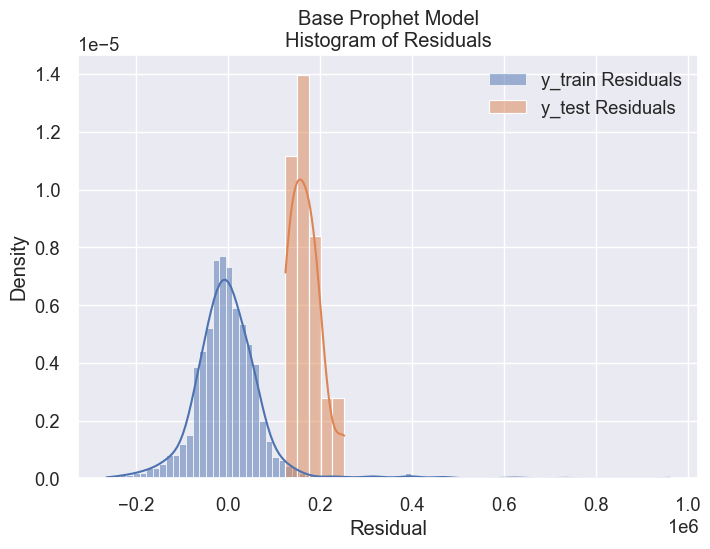

In [ ]:


# Generate the Prophet forecast plot
fig = plot_plotly(model, forecast_df, changepoints=True, xlabel='Date', ylabel='Value')

# Add the test actual data points
fig.add_trace(go.Scatter(
    x=y_test.ds, 
    y=y_test.y, 
    mode='lines', 
    name='Actual Data Points', 
    line=dict(color='green')
))

# Add titles and labels
fig.update_layout(
    title=f"{title} Model Forecast vs Actual Data",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Legend"
)

fig.show();

in_sample_eval_holder[f'{title} Model'] = residual_plotter(forecast_df.dropna(subset='y_train'), yhat_col='yhat', original_col='y_train', title=title)
out_of_sample_eval_holder[f'{title} Model'] = residual_plotter(forecast_df, yhat_col='yhat', original_col='y_test', title=title)
plt.legend();
plt.show()


 3b. Plot Cross-Validation Predictions


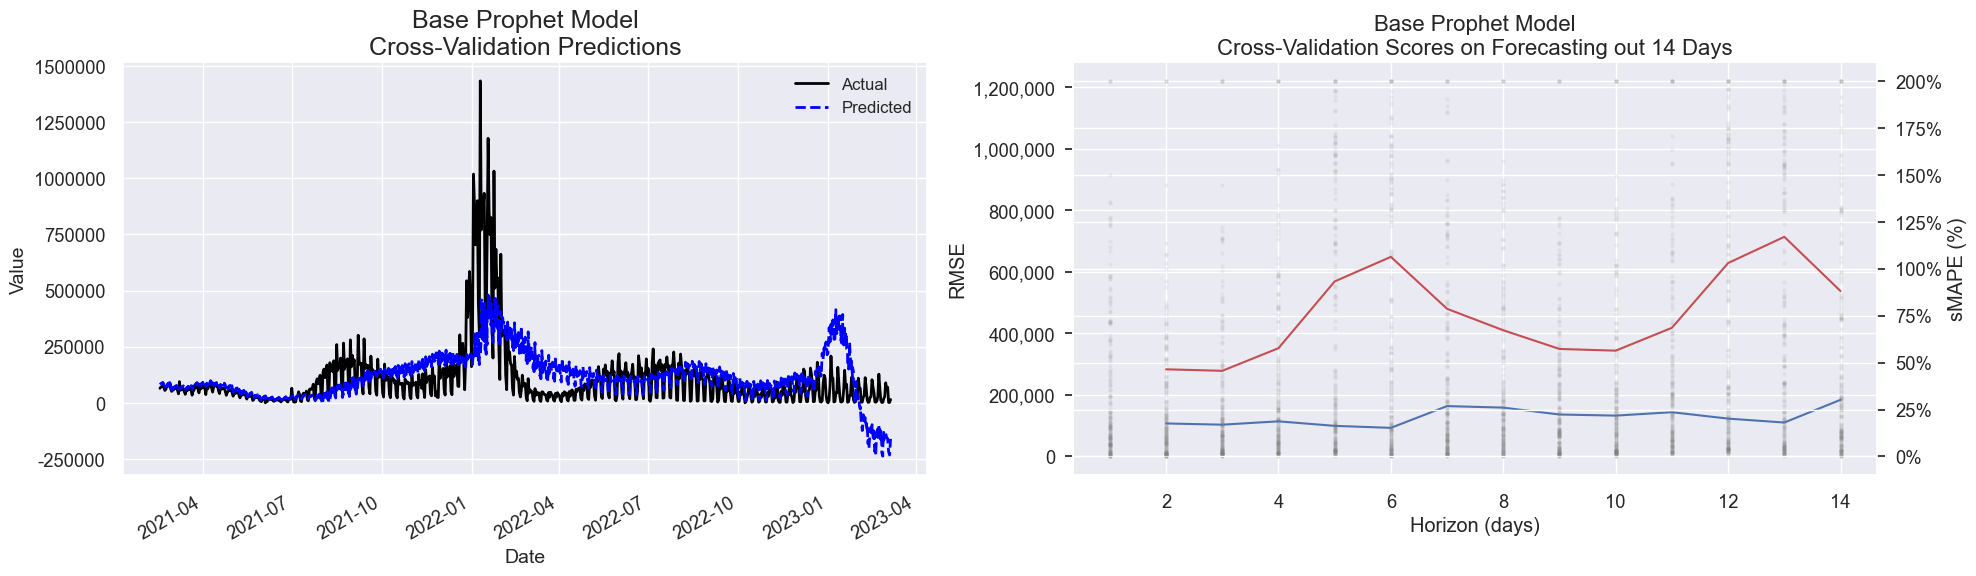

In [ ]:
val_eval_holder[f'{title} Model']  = prophet_cross_validation(model, title)
plt.show()




3c. Plot and Evaluate the Components


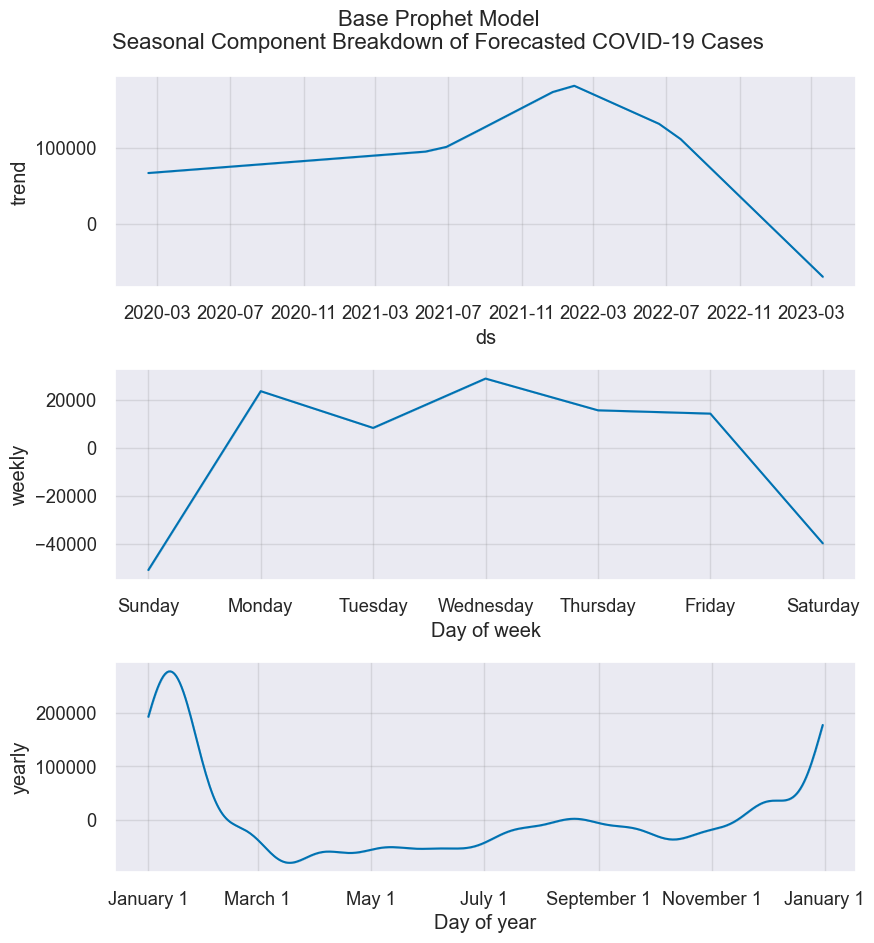

In [ ]:
fig = model.plot_components(forecast_df)
fig.suptitle(f'{title} Model\nSeasonal Component Breakdown of Forecasted COVID-19 Cases', y=1.05, fontsize=16)
fig.show();


# return the model, forecast_df, and make in_sample_eval_holder, out_of_sample_eval_holder, val_eval_holder global variables not limitted to the function scope


### <a id='toc3_1_4_'></a>[Review Model Performance and 14 Day Forecast](#toc0_)


In [ ]:

display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))



# # inputs
# model = Prophet(interval_width=0.95)

# ccast = COVIDCast(model, choose_your_date = choose_your_date, title = title)


Validation Metric,Base Prophet Model
mse,17021884564.594341
rmse,127688.182357
mae,80178.732360
mdape,1.083746
smape,0.757819
coverage,0.734692


In-Sample Metric,Base Prophet Model
R2,0.553408
MAE,52802.151925
RMSE,86427.920623
SMAPE,74.261333


# <a id='toc4_'></a>[Tuned Prophet Model](#toc0_)

## <a id='toc4_1_'></a>[Grid Search for Prophet Hyperparameters](#toc0_)

In [ ]:
# First param grid search
param_grid = {  
    'changepoint_prior_scale': np.logspace(-1,2, 4),
    'seasonality_prior_scale': np.logspace(-2,1, 4),
    'growth': ['linear', 'logistic', 'flat'],
}

# # Second param grid search
# param_grid = {  
#     'changepoint_prior_scale': np.logspace(-2, 0, 7),
#     'seasonality_prior_scale': np.logspace(-2, 2, 7),
# }

# slim_jim ={'Sparse': most_important, 'Excessive':frequently_removed_variables, 'Epid': epidemiological_variables}


# m = Prophet(changepoint_prior_scale = 7.5	, seasonality_prior_scale = 0.562341, 
#             interval_width=0.95, growth='linear')
# # m.add_country_holidays(country_name='US')

# for i in most_important:
#     m.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

# m.fit(train_df) # [values + ['ds', 'y' , 'floor', 'cap']]



In [ ]:

if True:
    # Python
    
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smapes = []
    coverage = []


    # Use cross validation to evaluate all parameters
    for params in tqdm(all_params):    
        
        m = Prophet(**params, interval_width=0.95)  # Fit model with given params
        # m.add_country_holidays(country_name='US')

        for i in most_important:
            m.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

        m.fit(train_df)
        
        df_cv = cross_validation(
            m, 
            initial=f"{initial_warmup_period} days", 
            period=f"{cutoff_period_prediction}", 
            horizon=f"{cutoff_period_prediction}",
            parallel="processes")

        
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smapes.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])
    
    # Find the best parameters

    tuning_results1 = pd.DataFrame(all_params)
    tuning_results1['rmse'] = rmses
    tuning_results1['mae'] = mae
    tuning_results1['smapes'] = smapes
    tuning_results1['coverage'] = coverage



    best_params = all_params[np.argmin(rmses)]
    print(best_params)



  0%|          | 0/48 [00:00<?, ?it/s]

16:40:08 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:15 - cmdstanpy - INFO - Chain [1] start processing
16:43:15 - cmdstanpy - INFO - Chain [1] done processing
16:43:48 - cmdstanpy - INFO - Chain [1] start processing
16:43:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] start processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:45:55 - cmdstanpy - INFO - Chain [1] start processing
16:45:55 - cmdstanpy - INFO - Chain [1] done processing
16:46:28 - cmdstanpy - INFO - Chain [1] start processing
16:46:28 - cmdstanpy - INFO - Chain [1] done processing
16:47:10 - cmdstanpy - INFO - Chain [1] start processing
16:47:10 - cmdstanpy - INFO - Chain [1] done processing
16:48:20 - cmdstanpy - INFO - Chain [1] start processing
16:48:20 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 10.0, 'seasonality_prior_scale': 0.1, 'growth': 'linear'}


In [ ]:
tuning_results1['compo'] = tuning_results1['rmse'] + tuning_results1['mae'] * (1 - tuning_results1['coverage'])

tuning_results1.sort_values(by='compo').style.background_gradient(cmap='coolwarm', subset=['smapes','mae', 'rmse', 'compo', 'coverage'])
    


,changepoint_prior_scale,seasonality_prior_scale,growth,rmse,mae,smapes,coverage,compo
27,10.000000,0.100000,linear,74841.018590,37455.773936,0.519183,0.863818,79941.804894
36,100.000000,0.010000,linear,74975.347173,37865.636782,0.538261,0.866489,80030.839400
24,10.000000,0.010000,linear,74996.629679,37931.879859,0.537467,0.866489,80060.966109
39,100.000000,0.100000,linear,75361.359574,37890.233381,0.523269,0.870494,80268.372442
15,1.000000,0.100000,linear,75700.243445,38390.210596,0.547179,0.877170,80415.729927
18,1.000000,1.000000,linear,75844.795585,38603.175815,0.553427,0.875834,80637.980299
45,100.000000,10.000000,linear,75698.300428,38302.768701,0.522696,0.869159,80709.877641
30,10.000000,1.000000,linear,75629.647633,37818.496653,0.515236,0.865154,80729.338102
33,10.000000,10.000000,linear,75536.882084,37914.262012,0.515600,0.862483,80750.725859
42,100.000000,1.000000,linear,75910.915710,38109.184747,0.519525,0.871829,80795.404008


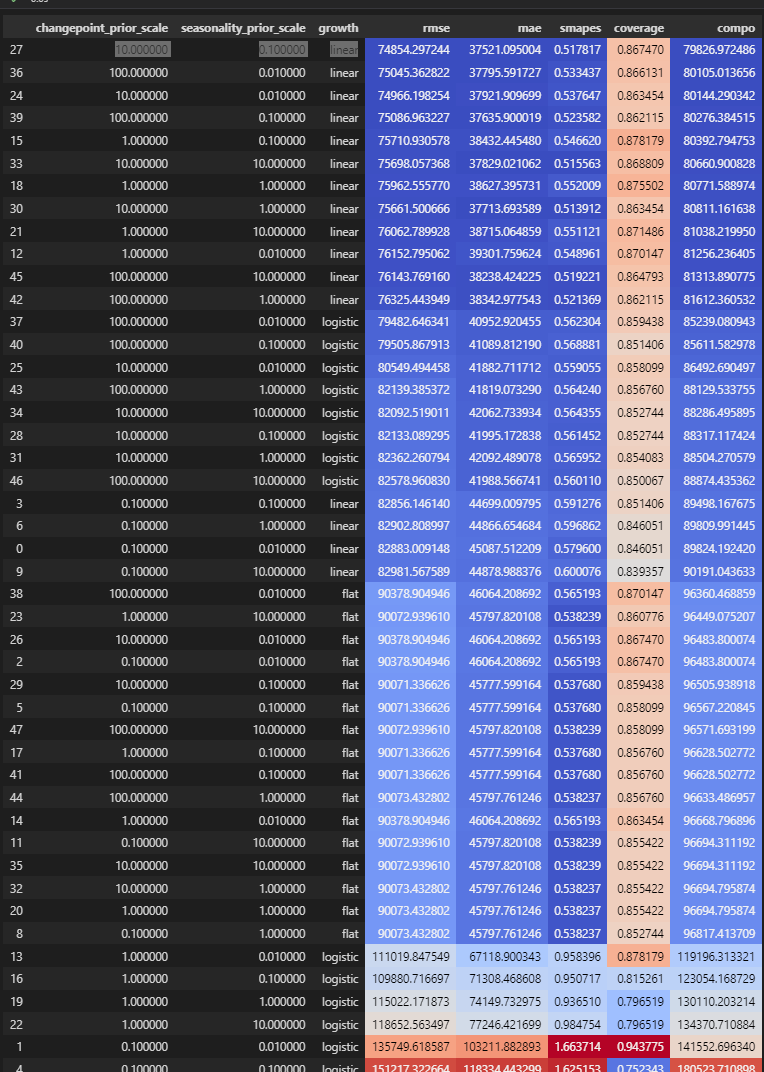

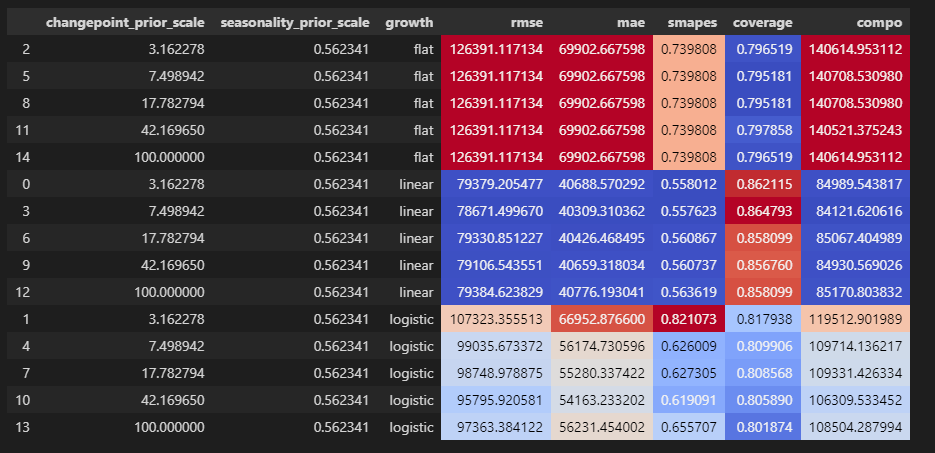

## <a id='toc4_2_'></a>[Tuned Model of Prophet](#toc0_)

#### <a id='toc4_2_1_1_'></a>[Model Initialization](#toc0_)


In [ ]:
title = 'Tuned Prophet'

model2 = Prophet(changepoint_prior_scale = 7.5	, seasonality_prior_scale = 0.562341, 
                interval_width=0.95, growth='linear')
model2.add_country_holidays(country_name='US')

model2.fit(y_train)

17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing



#### <a id='toc4_2_1_2_'></a>[Forecast Generation](#toc0_)


In [ ]:

forecast_df = forecast_df_complete(model2, y_train, y_test)

forecast_df.head(2)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y_train,y_test
0,2020-02-15,240964.253325,-171044.986702,71874.703405,240964.253325,240964.253325,0.0,0.0,0.0,0.0,...,-40315.709871,-248870.516066,-248870.516066,-248870.516066,0.0,0.0,0.0,-48221.972612,0.0,NaN
1,2020-02-16,235356.349559,-183873.196265,64221.008281,235356.349559,235356.349559,0.0,0.0,0.0,0.0,...,-51702.795998,-242805.179601,-242805.179601,-242805.179601,0.0,0.0,0.0,-59151.626040,0.0,NaN


#### <a id='toc4_2_1_3_'></a>[Model Evaluation](#toc0_)


### 3a. Plot In-Sample and Out-Of-Sample Predictions

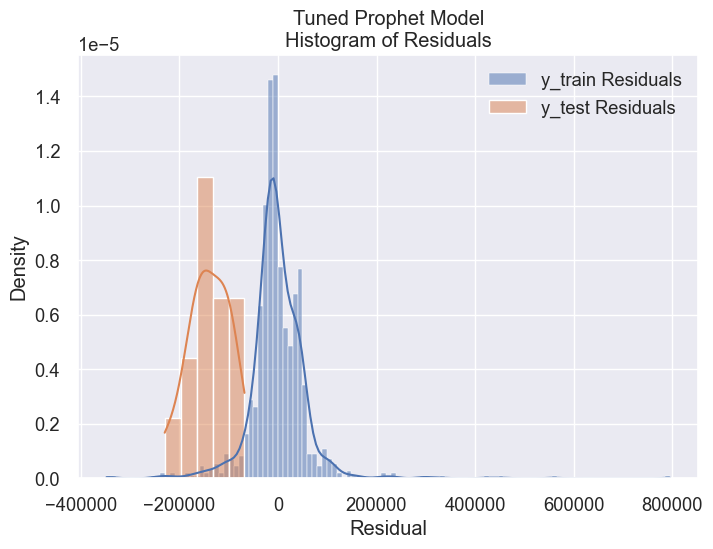

### 3b. Plot Cross-Validation Predictions

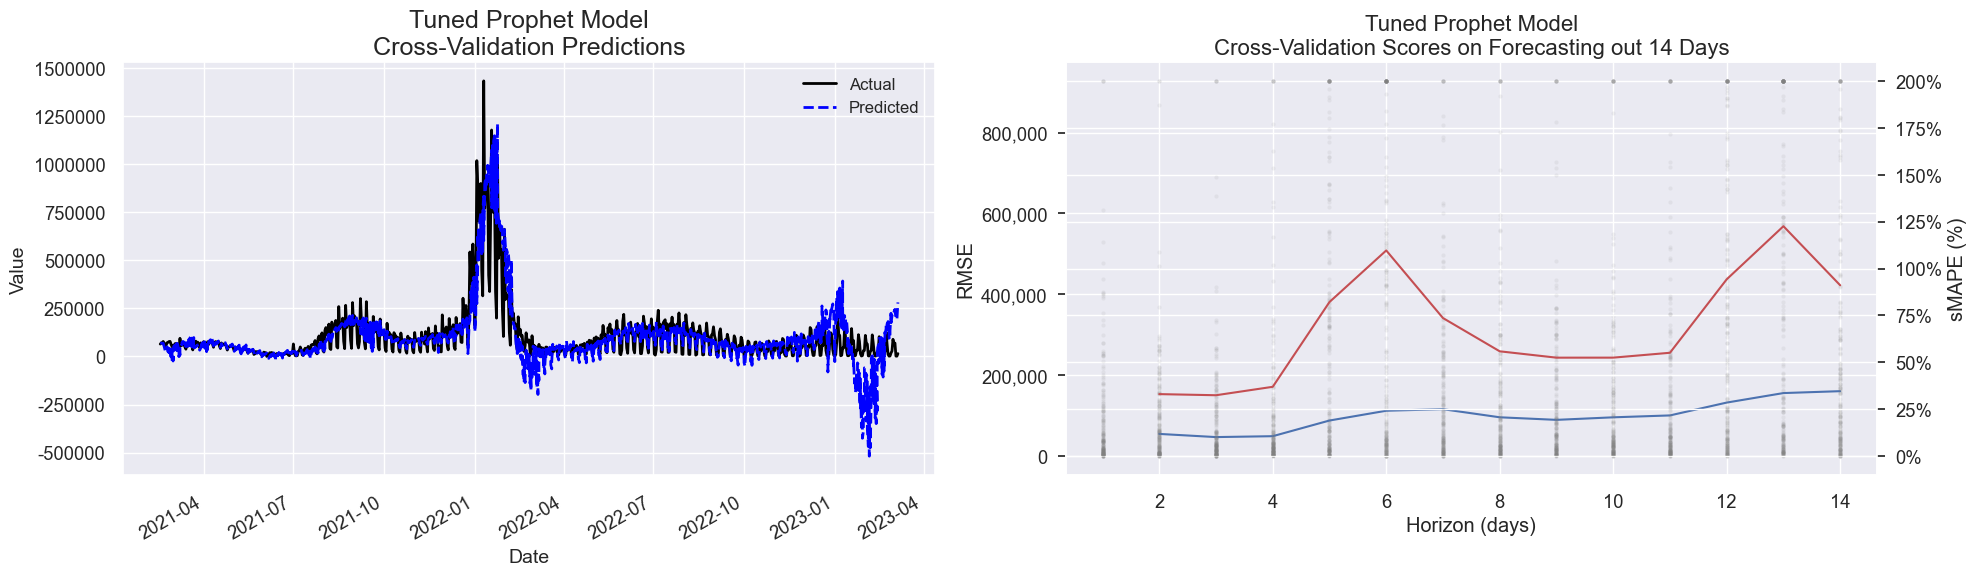

### 3c. Plot the Components and Interpret

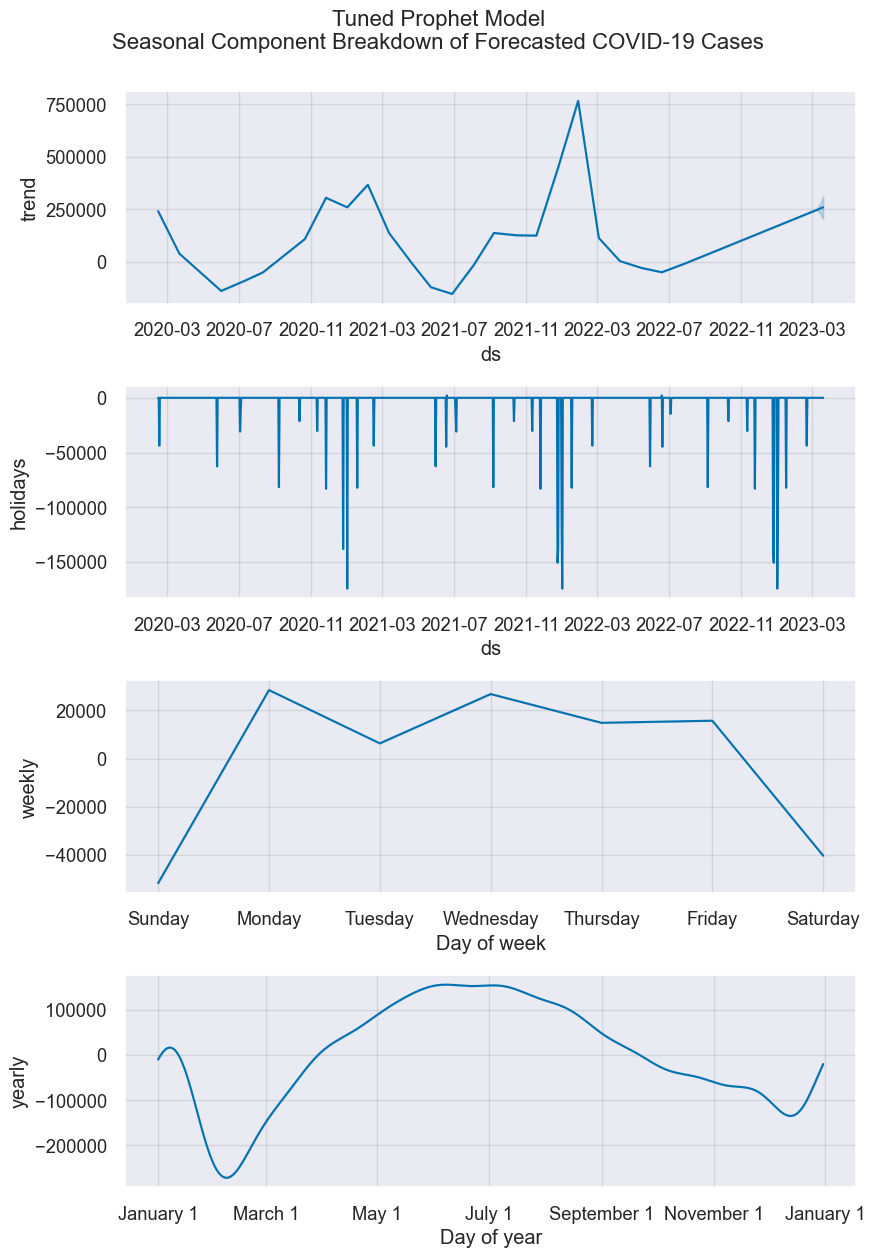

In [ ]:

prophet_model_eval_pipeline(model2, forecast_df=forecast_df, title=title)


#### <a id='toc4_2_1_4_'></a>[Review Model Performance and 14 Day Forecast](#toc0_)


In [ ]:

display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
# display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))



# # inputs
# model2 = Prophet(changepoint_prior_scale = 0.031623, seasonality_prior_scale = 0.046416)
# model2.add_country_holidays(country_name='US')

# ccast = COVIDCast(model2, choose_your_date, title)


Validation Metric,Base Prophet Model,Tuned Prophet Model
mse,17021884564.594341,11228656432.687195
rmse,127688.182357,100014.298045
mae,80178.732360,56555.170670
mdape,1.083746,0.742379
smape,0.757819,0.686183
coverage,0.734692,0.762043


In-Sample Metric,Base Prophet Model,Tuned Prophet Model
R2,0.553408,0.760817
MAE,52802.151925,36970.830647
RMSE,86427.920623,63250.542165
SMAPE,74.261333,66.362872



# <a id='toc5_'></a>[Prophet Model with Tuning and Exogenous Variables](#toc0_)

Facebook Prophet can incorporate exogenous features. Lets look at some combinations. To choose combinations I focused on a priori differences (groupings of different variables), improving interpretability by reducing Multi-colinearity, and capturing the most variance with PCA.  


## <a id='toc5_1_'></a>[Feature Selection](#toc0_)

In [ ]:


# Assuming train_df is your dataframe and 'y' is the target column

X = train_df[Not_Colin]
y = train_df['y']

# Train a random forest model
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X, y)

# Get feature importances
importances = forest.feature_importances_


# Create a dataframe for the importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the dataframe by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

# You can then select the top N features based on importance
top_10 = features_df['Feature'][:10].tolist()  # Top 10 features

top_20 = features_df['Feature'][:20].tolist()  # Top 20 features

top_30 = features_df['Feature'][:30].tolist()  # Top 30 features

features_df.count()

                                 Feature    Importance
9          current_hospitalized_patients  5.955265e-01
1                              new_fatal  5.900949e-02
21                      new_vaccinations  4.009788e-02
29            new_bi_weekly_vaccinations  3.468095e-02
4                              dayofweek  2.736736e-02
18                  t/k_mortality_period  2.710278e-02
7                       excess_mortality  2.614208e-02
23                   t/s_recovery_period  2.246511e-02
24                             dayofyear  2.108169e-02
32                     sig_recovery_rate  2.041290e-02
28                    kap_mortality_rate  1.530651e-02
16  excess_mortality_cumulative_absolute  1.210676e-02
3                people_fully_vaccinated  1.139484e-02
0              derived_reproduction_rate  1.079718e-02
33                     transport_closing  1.004143e-02
17                                 fatal  8.961697e-03
15                     people_vaccinated  8.120803e-03
25        

Feature       36
Importance    36
dtype: int64

In [ ]:
frequently_removed_variables

['derived_reproduction_rate',
 'new_fatal',
 'cancel_events',
 'dayofweek',
 'rho_transmission_rate',
 'gatherings_restrictions',
 'testing_policy',
 'current_hospitalized_patients',
 'quarter',
 'information_campaigns',
 'internal_movement_restrictions',
 't/k_mortality_period',
 'year',
 'international_movement_restrictions',
 'new_vaccinations',
 'workplace_closing',
 't/s_recovery_period',
 'dayofyear',
 't/r_infection_period',
 'current_intensive_care_patients',
 'school_closing',
 'kap_mortality_rate',
 'new_bi_weekly_vaccinations',
 'month',
 'sig_recovery_rate',
 'transport_closing',
 'total_vaccinations',
 'stay_home_restrictions',
 'stringency_index']

In [ ]:
variable_dicts = {'All': all_variables, 'Colinear': colinear_variables, 'Not_Colin': Not_Colin,
                'Sparse': most_important, 'Big': somewhat_important, 'top_10': top_10, 'top_20': top_20, 'top_30': top_30,
                'Excessive':frequently_removed_variables, 'Not_Epid': list(set(all_variables) - set(epidemiological_variables)),
                'SIRD': sird_variables, "Government": restriction_variables, 'Epid': epidemiological_variables,
                'Dates': date_variables, 'Not_Epi_Col': list((set(all_variables) - set(epidemiological_variables)) - set(colinear_variables))}


In [ ]:

# add constant to make sure that the the vif has an intercept
train_df = add_constant(train_df)

# VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = variable_dicts['All'] + ['const']

list_of_vifs = []

for i, k in variable_dicts.items():
    # print(i, len(k))

    # Ensure that the data is numeric
    numeric_cols = k + ['const']
    # print(numeric_cols)
    list_of_vifs.append(
        pd.Series(name = i, index=numeric_cols, 
            data = [variance_inflation_factor(train_df[numeric_cols].values, i) for i in range(len(numeric_cols))]
            ))

vif_df = reduce(lambda x, y: pd.merge(x, y, how='outer', left_on='Feature', right_index=True), [vif_data] + list_of_vifs)

train_df.drop(columns='const', inplace=True)

display(vif_df.sort_values(by='Not_Colin', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))


,Feature,All,Colinear,Not_Colin,Sparse,Big,top_10,top_20,top_30,Excessive,Not_Epid,SIRD,Government,Epid,Dates,Not_Epi_Col
38,month,88540.647957,nan,83923.770216,nan,23.758802,nan,nan,79331.345889,165.931064,70238.635306,nan,nan,nan,20705.229220,57928.643608
40,dayofyear,87851.096134,nan,83411.473089,nan,nan,1.457858,3.256271,79009.026678,171.531505,69647.538944,nan,nan,nan,20938.482223,58269.716951
20,people_vaccinated,8464.959151,nan,8108.476491,nan,nan,nan,4347.566493,7155.793959,nan,nan,nan,nan,3055.897673,nan,nan
9,fatal,inf,nan,7170.953503,nan,nan,nan,1517.446027,4836.058750,nan,nan,nan,nan,1152.892679,nan,nan
8,excess_mortality_cumulative_absolute,5820.163046,nan,5511.658134,nan,nan,nan,1027.954723,3463.477545,nan,nan,nan,nan,975.267332,nan,nan
19,people_fully_vaccinated,6909.900498,nan,4960.294189,nan,nan,nan,3252.574104,4510.437060,nan,nan,nan,nan,2155.142105,nan,nan
33,total_vaccinations,3428.532742,nan,2499.702710,nan,35.863325,nan,nan,2076.839135,150.374372,nan,nan,nan,524.445479,nan,nan
39,year,1122.480531,nan,910.096945,nan,nan,nan,nan,742.603427,203.003530,266.887373,nan,nan,nan,1.132562,36.464413
41,dayofmonth,618.128221,nan,587.227315,nan,1.048372,nan,1.029964,557.206257,nan,491.077412,nan,nan,nan,145.644497,406.217858
26,stringency_index,457.137144,nan,417.803690,1.745348,204.309360,nan,nan,33.771926,321.568576,165.590782,nan,133.864329,nan,nan,154.914806


In [ ]:

if False:
    # Python
    # Generate all combinations of parameters
    rmses = []  # Store the RMSEs for each params here
    mae = []
    smapes = []
    coverage = []
    all_the_future_df = dict()

    # Use cross validation to evaluate all parameters
    for key, values in tqdm(variable_dicts.items()):    
        m = Prophet(changepoint_prior_scale = 7.5	, seasonality_prior_scale = 0.562341, 
                    interval_width=0.95, growth='linear')
        m.add_country_holidays(country_name='US')

        for i in values:
            m.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

        m.fit(train_df) # [values + ['ds', 'y' , 'floor', 'cap']]

        df_cv = cross_validation(
            m, 
            initial=f"{initial_warmup_period} days", 
            horizon=f"{cutoff_period_prediction} days",
            parallel="processes")

        
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        mae.append(df_p['mae'].values[0])
        smapes.append(df_p['smape'].values[0])
        coverage.append(df_p['coverage'].values[0])
        
        all_the_future_df[key] = forecast_df_complete(model, y_train, y_test, master_df)
        

    # Find the best parameters
    tuning_results1 = pd.DataFrame(variable_dicts.keys())
    tuning_results1['rmse'] = rmses
    tuning_results1['mae'] = mae
    tuning_results1['smape'] = smapes
    tuning_results1['coverage'] = coverage

    tuning_results1


In [ ]:

# tuning_results1['compo'] = tuning_results1['rmse'] + tuning_results1['mae'] * (1 - tuning_results1['coverage'])
# tuning_results1.sort_values(by='compo').style.background_gradient(cmap='coolwarm', subset=['smape','mae', 'rmse', 'compo', 'coverage'])



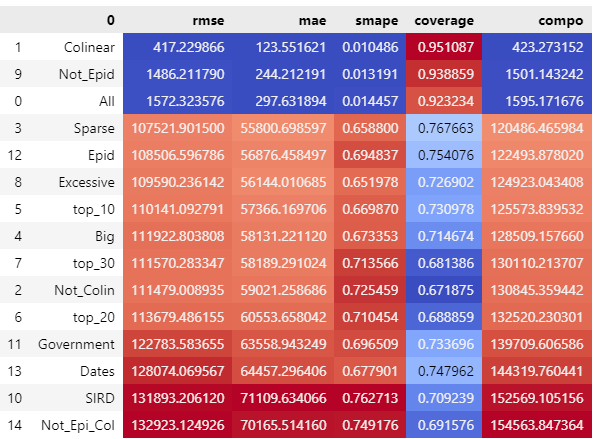

## <a id='toc5_2_'></a>[Tuned and Exogenous Model of Prophet](#toc0_)

Model 1

In [ ]:
# title= 'Prophet Tuned and Sparse Exogenous Model 1'
# exogenous_variables = most_important



Model 1

In [ ]:
# title = 'Prophet Tuned and Epidemiology Final Exogenous Model 2'
# exogenous_variables = epidemiological_variables


Model 3

In [ ]:
# title= 'Prophet Tuned and Very Large Exogenous Model 3'
# exogenous_variables = frequently_removed_variables

# model = Prophet(changepoint_prior_scale = 7.50, seasonality_prior_scale = 0.56, 
#                 interval_width=0.95, growth='linear')
# model.add_country_holidays(country_name='US')



Model 4

In [ ]:
# title= 'Prophet Tuned and Somewhat Important Exogenous Model 4'
# exogenous_variables = somewhat_important


Other Models

In [ ]:
title= 'Prophet Tuned and Hospitalizations and SIRD Model 8'
exogenous_variables = epidemiological_variables + sird_variables



#### <a id='toc5_2_1_1_'></a>[Model Initialization](#toc0_)


In [ ]:


model = Prophet(changepoint_prior_scale = 10.000000, seasonality_prior_scale = 0.100000, 
                interval_width=0.95, growth='linear')

for i in exogenous_variables:
    model.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

model = model.fit(train_df)


17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing



#### <a id='toc5_2_1_2_'></a>[Forecast Generation](#toc0_)


In [ ]:

forecast_df = forecast_df_complete(model, y_train, y_test, master_df).drop(columns = ['cap'])
forecast_df.head(2)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,current_hospitalized_patients,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y_train,y_test
0,2020-02-15,-1.461527e+06,-137898.753002,60465.391420,-1.461527e+06,-1.461527e+06,1.426895e+06,1.426895e+06,1.426895e+06,-450010.370493,...,-24448.288548,86037.977834,86037.977834,86037.977834,0.0,0.0,0.0,-34631.925554,0.0,NaN
1,2020-02-16,-1.458390e+06,-141507.942198,71440.548503,-1.458390e+06,-1.458390e+06,1.422400e+06,1.422400e+06,1.422400e+06,-450010.370493,...,-26890.551102,86828.060246,86828.060246,86828.060246,0.0,0.0,0.0,-35989.582932,0.0,NaN


#### <a id='toc5_2_1_3_'></a>[Model Evaluation](#toc0_)


### 3a. Plot In-Sample and Out-Of-Sample Predictions

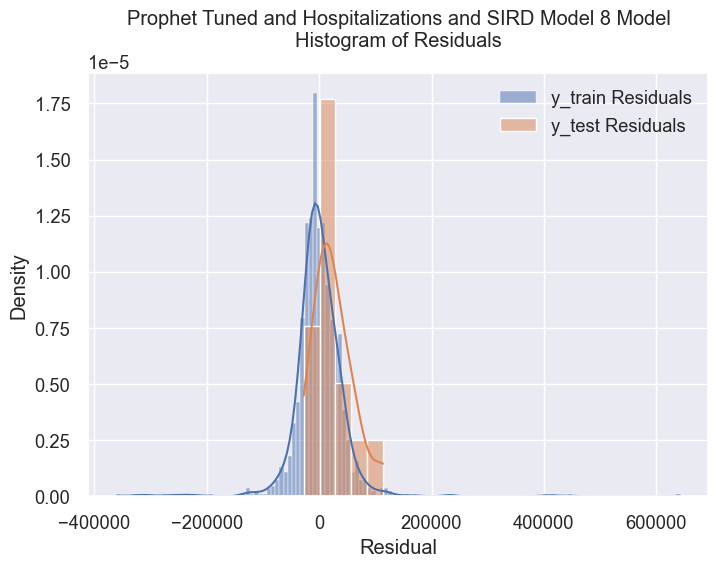

### 3b. Plot Cross-Validation Predictions

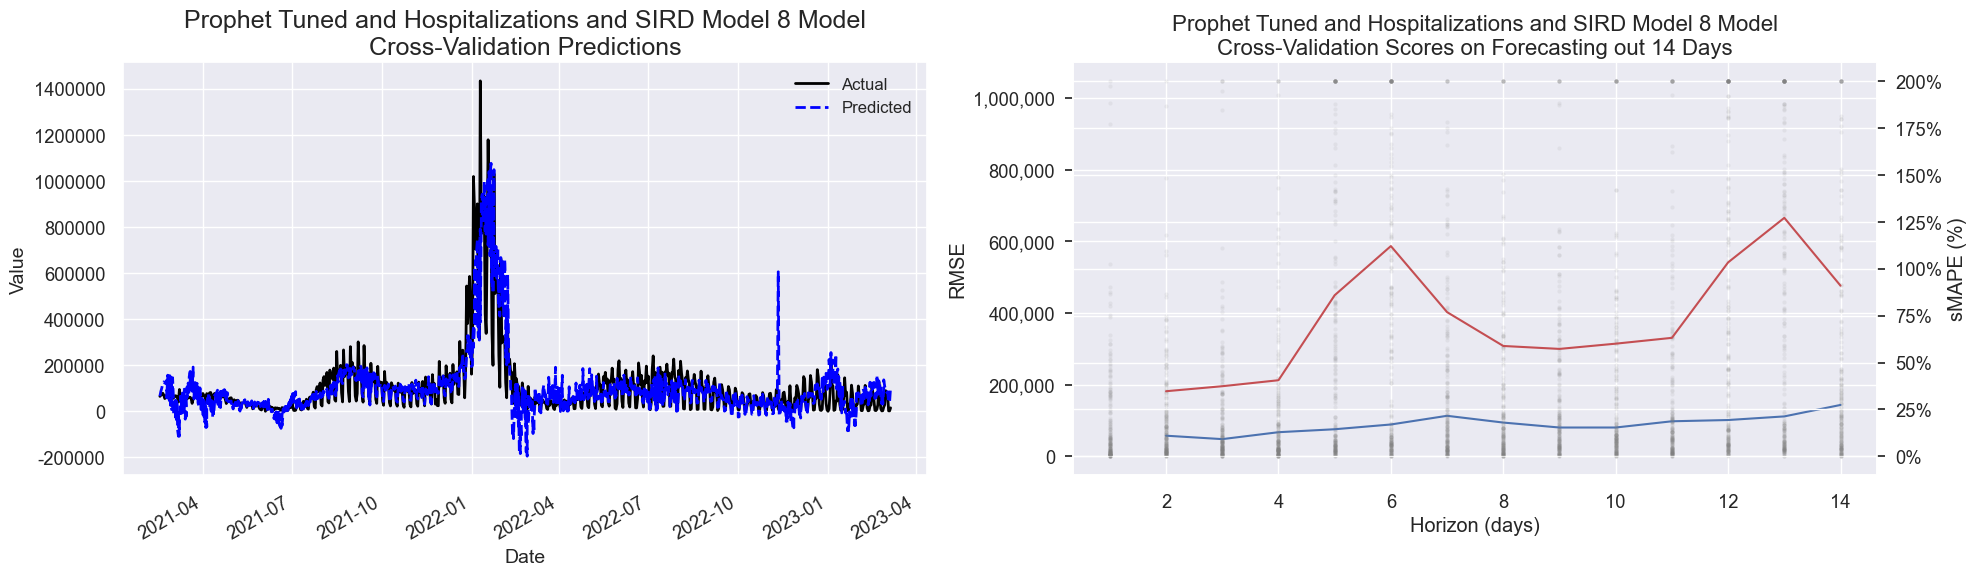

### 3c. Plot the Components and Interpret

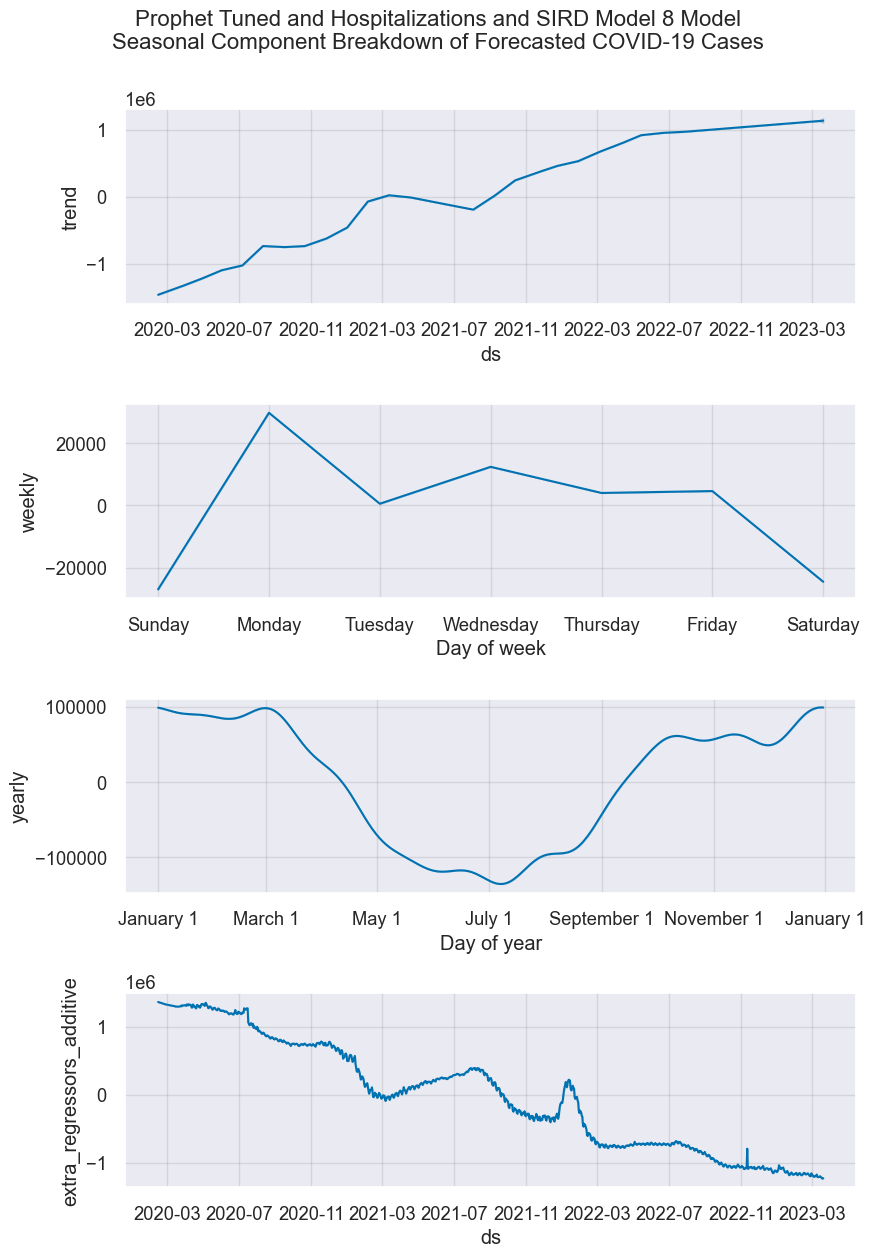

In [ ]:


prophet_model_eval_pipeline(model, forecast_df=forecast_df, title=title)



#### <a id='toc5_2_1_4_'></a>[Review Model Performance and 14 Day Forecast](#toc0_)


Validation Metric,Base Prophet Model,Tuned Prophet Model,Prophet Tuned and Hospitalizations and SIRD Model 8 Model
mse,17021884564.594341,11228656432.687195,8486805286.604864
rmse,127688.182357,100014.298045,88823.147705
mae,80178.732360,56555.170670,51658.257804
mdape,1.083746,0.742379,0.767004
smape,0.757819,0.686183,0.729245
coverage,0.734692,0.762043,0.736741


In-Sample Metric,Base Prophet Model,Tuned Prophet Model,Prophet Tuned and Hospitalizations and SIRD Model 8 Model
R2,0.553408,0.760817,0.835714
MAE,52802.151925,36970.830647,29012.402790
RMSE,86427.920623,63250.542165,52420.294520
SMAPE,74.261333,66.362872,58.746927


Out-of-Sample Metric,Base Prophet Model,Tuned Prophet Model,Prophet Tuned and Hospitalizations and SIRD Model 8 Model
R2,-20.715083,-15.029785,-0.364549
MAE,166461.593829,139776.931392,30978.419133
RMSE,169823.665739,145908.739779,42570.824120
SMAPE,200.000000,151.506481,132.017512


17:38:30 - cmdstanpy - INFO - Chain [1] start processing
17:38:31 - cmdstanpy - INFO - Chain [1] done processing


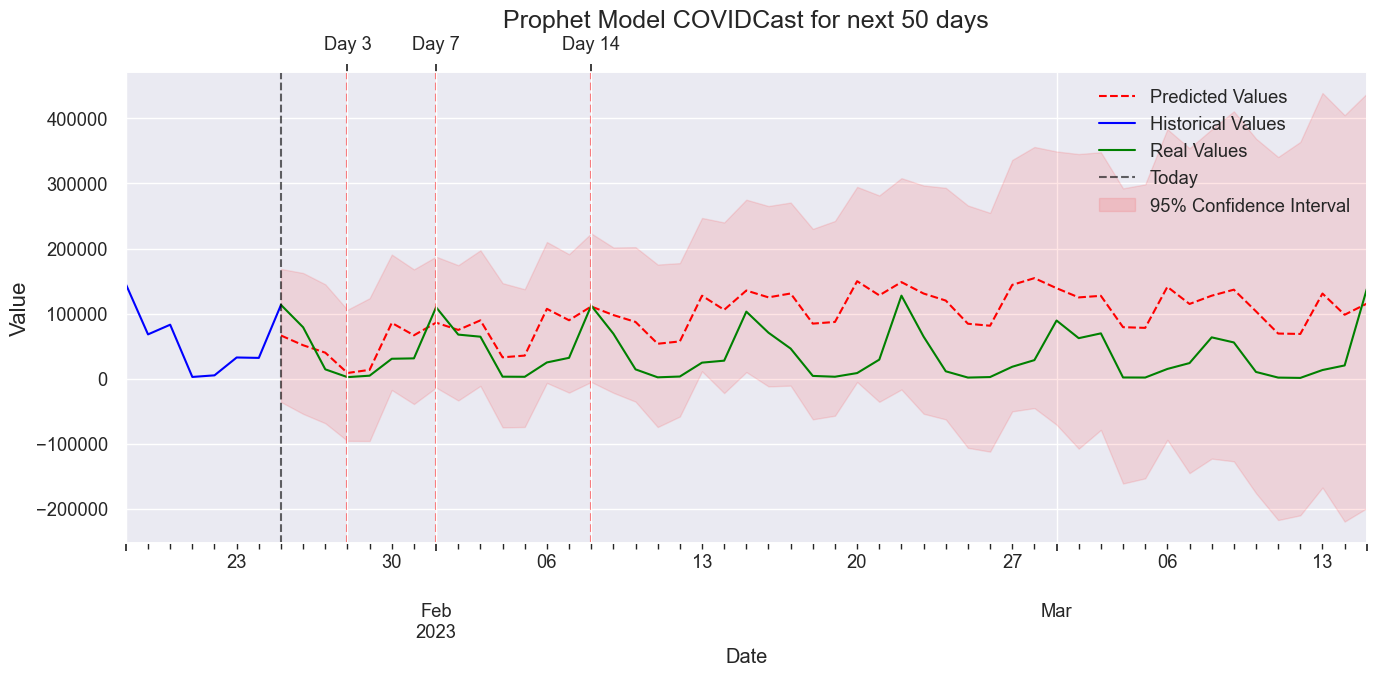

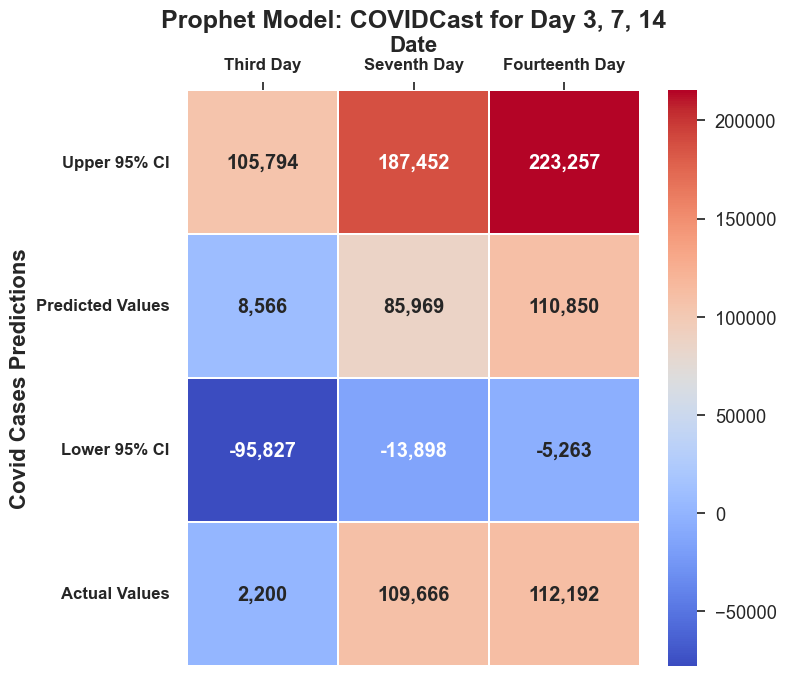

In [ ]:
# val_eval_holder = val_eval_holder.iloc[:,1:]

display(val_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(in_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))
display(out_of_sample_eval_holder.style.background_gradient(cmap='coolwarm', axis=1))

# Inputs

covid_prophet = Prophet(changepoint_prior_scale = 10.000000, seasonality_prior_scale = 0.100000, 
                interval_width=0.95, growth='linear')
# covid_prophet.add_country_holidays(country_name='US')

for i in exogenous_variables:
    covid_prophet.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

ccast = COVIDCast(covid_prophet, pd.to_datetime('2023-01-25'),  
                horizon = 16, exogenous = exogenous_variables)

# <a id='toc6_'></a>[Best COVID Forecaster](#toc0_)

17:38:51 - cmdstanpy - INFO - Chain [1] start processing
17:38:52 - cmdstanpy - INFO - Chain [1] done processing


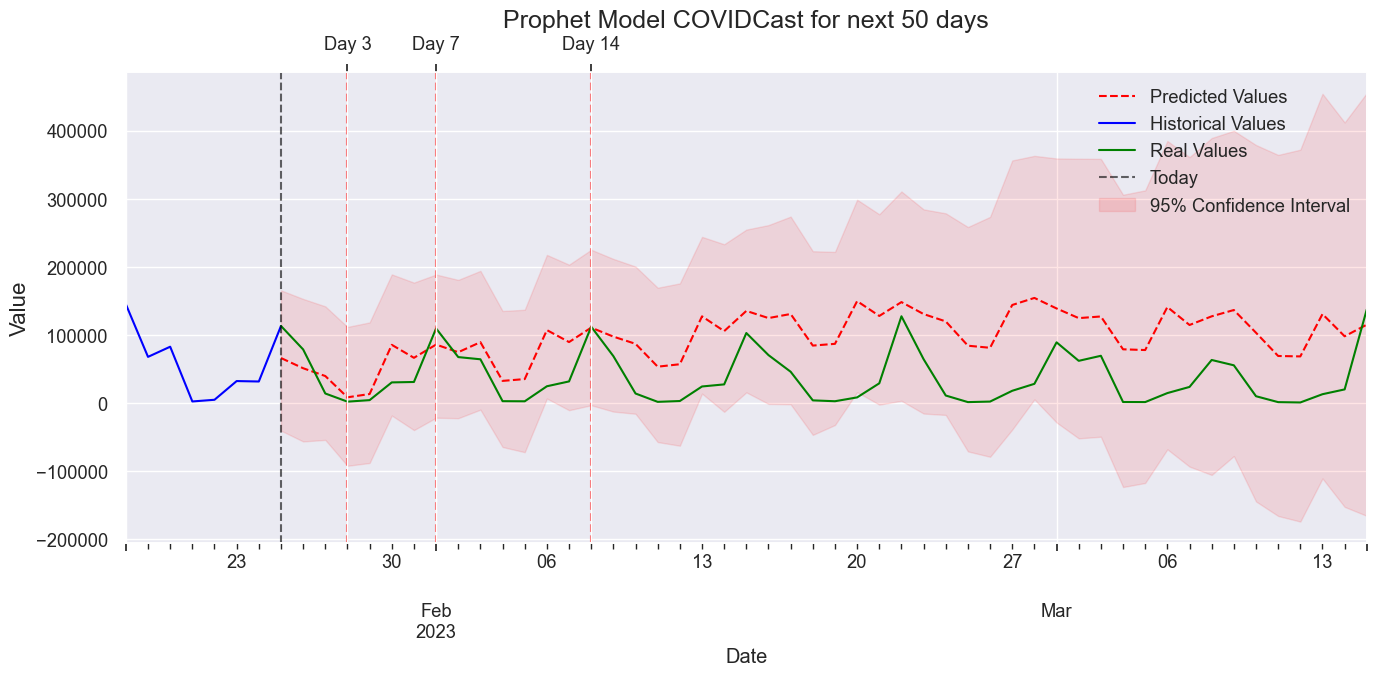

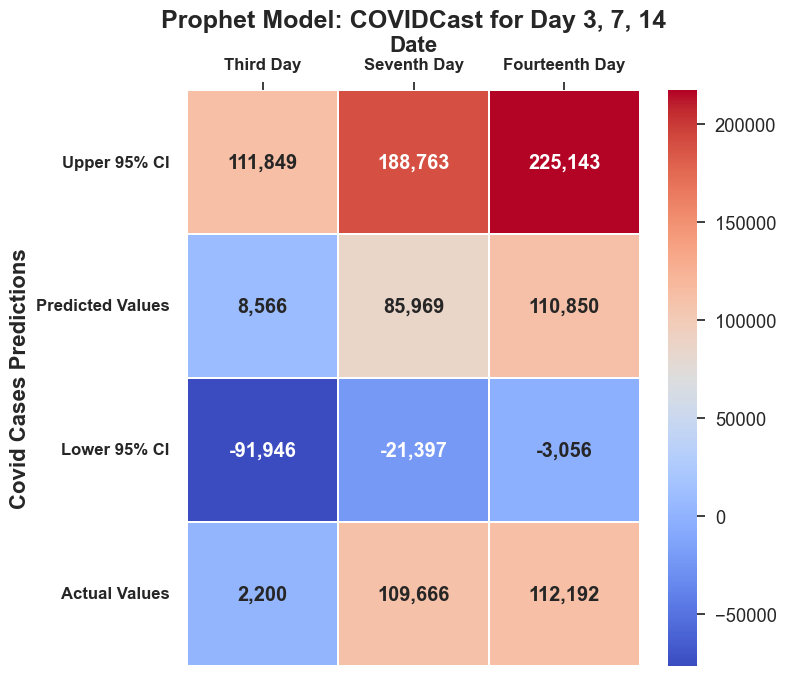

In [ ]:


covid_prophet = Prophet(changepoint_prior_scale = 10.000000, seasonality_prior_scale = 0.100000, 
                interval_width=0.95, growth='linear')
# covid_prophet.add_country_holidays(country_name='US')

for i in exogenous_variables:
    covid_prophet.add_regressor(i, prior_scale = .5, standardize='auto', mode='additive')

ccast = COVIDCast(covid_prophet, pd.to_datetime('2023-01-25'),  
                horizon = 16, exogenous = exogenous_variables)